# Chapter 5 텍스트 생성

<img alt="LM Meta Learning" width="800" caption="During pretraining, language models are exposed to sequences of tasks that can be adapted during inference (courtesy of Tom B. Brown)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter05_lm-meta-learning.png?raw=1" id="lm-meta-learning"/>

```
사전 훈련 동안 언어 모델은 작업 시퀀스에 노출되고 이를 바탕으로 추론에 적용할 수 있음
```

<img alt="Meena" width="300" caption="Meena on the left telling a corny joke to a human on the right (courtesy of Daniel Adiwardana and Thang Luong)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter05_meena.png?raw=1" id="meena"/>

```
사람(오른쪽)에게 진부한 농담을 던지는 Meena(왼쪽)
```

## 5.1 일관성 있는 텍스트 생성의 어려움

```
텍스트 생성에만 따르는 특수한 어려움
```

- 디코딩은 반복적으로 수행되므로 입력이 모델의 정방향 패스를 한 번 통과할 때보다 많은 계산이 필요함
- 생성된 텍스트의 품질과 다양성은 디코딩 방법과 이에 관련된 하이퍼파라미터에 따라 달라짐

<img alt="Text generation" width="700" caption="Generating text from an input sequence by adding a new word to the input at each step" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter05_text-generation.png?raw=1" id="text-generation"/> 

```
스텝마다 새로운 단어를 입력 시퀀스에 추가해 텍스트 생성하기
```

> 출력 시퀀스가 입력 프롬프트에 따라 결정되므로 이런 종류의 텍스트 생성을 종종 조건부 텍스트 생성(conditional text generation)이라 함

## 5.2 그리디 서치 디코딩

```
연속적인 모델 출력에서 이산적인 토큰을 얻는 가장 간단한 디코딩 방법은 각 타임스텝에서 확률이 가장 높은 토큰을 탐욕적(greedily)으로 선택하는 것임
```

In [1]:
import torch

from transformers import AutoTokenizer, AutoModelForCausalLM

2023-01-30 19:54:47.288097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 19:54:47.895019: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
2023-01-30 19:54:47.895076: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64:
2023-01-30 19:54:47.895082: W tensorflow

In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPU 2 to use

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 코랩의 경우 gpt2-xl 을 사용하면 메모리 부족 에러가 발생
# 대신 'gpt' 또는 'gpt2-large' 로 지정하거나 코랩 프로를 사용
model_name = 'gpt2-xl'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.99G [00:00<?, ?B/s]

In [4]:
import pandas as pd

In [7]:
input_txt = 'Transformers are the'
input_ids = tokenizer(input_txt, return_tensors='pt')['input_ids'].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration['Input'] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        
        # 첫 번째 배치의 마지막 토큰의 로짓을 선택해 소프트맥스를 적용합니다.
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        
        # 가장 높은 확률의 토큰을 저장합니다.
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f'{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)'
            )
            iteration[f'Choice {choice_idx+1}'] = token_choice
            
        # 예측한 다음 토큰을 입력에 추가합니다.
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

In [8]:
pd.DataFrame(iterations)

,Input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,most (8.53%),only (4.96%),best (4.65%),Transformers (4.37%),ultimate (2.16%)
1,Transformers are the most,popular (16.78%),powerful (5.37%),common (4.96%),famous (3.72%),successful (3.20%)
2,Transformers are the most popular,toy (10.63%),toys (7.23%),Transformers (6.60%),of (5.46%),and (3.76%)
3,Transformers are the most popular toy,line (34.38%),in (18.20%),of (11.71%),brand (6.10%),line (2.69%)
4,Transformers are the most popular toy line,in (46.28%),of (15.09%),", (4.94%)",on (4.40%),ever (2.72%)
5,Transformers are the most popular toy line in,the (65.99%),history (12.42%),America (6.91%),Japan (2.44%),North (1.40%)
6,Transformers are the most popular toy line in the,world (69.26%),United (4.55%),history (4.29%),US (4.23%),U (2.30%)
7,Transformers are the most popular toy line in ...,", (39.73%)",. (30.64%),and (9.87%),with (2.32%),today (1.74%)


```
간단한 방법을 사용해 "Transformers are the most popular toy line in the world(트랜스포머는 세상에서 가장 유명한 장난감 시리즈다)"란 문장을 생성했음

흥미롭게도 여기서 GPT 는 두 장난감 회사(해즈브로(Hasbro)와 타가라토미(Takara Tomy))가 만든 트랜스포머 프랜차이즈를 알고 있음

그리드 서치 구현은 어렵지 않지만, 더 복잡한 디코딩 방법을 알아보기 위해 트랜스포머스에 내장된 generate() 함수를 사용하겠음
```

In [9]:
input_ids = tokenizer(input_txt, return_tensors='pt')['input_ids'].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Transformers are the most popular toy line in the world,


```
OpenAI 의 유니콘 기사를 재현할 수 있을까?

앞에서 처럼 토크나이저로 프롬프트를 인코딩하고 긴 텍스트 시퀀스를 생성하기 위해 max_length 에 큰 값을 지정하겠음
```

In [11]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""

input_ids = tokenizer(input_txt, return_tensors='pt')['input_ids'].to(device)
output_greedy = model.generate(input_ids, max_length=max_length,
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able


```
이 기사의 앞머리에 있는 몇 문장은 OpenAI 가 작성한 기사와 매우 다를 뿐만 아니라 재미있게도 발견에 기여한 대학이 여러곳임

여기서 그리드 서치 디코딩의 주요 단점 하나가 드러남

그리드 서치 알고리즘은 반복적인 출력 시퀀스를 생성하는 경향이 있어서 뉴스 기사로는 확실히 적절하지 않음

이는 그리드 서치 알고리즘의 보편적인 문제이며, 이로 인해 최적의 솔루션을 만들어내기 어려움

디코딩 측면에서 보면, 확률이 높은 당너가 확률이 낮은 단어보다 먼저 등장하기 때문에 전체적으로 확률이 높은 단어 시퀀스를 생성하지 못하기도 함

다행히 더 나은 방법이 있음

빔 서치 디코딩(Beam Search Decoding)이라는 인기 있는 방법을 알아보자
```

> 그리디 서치 디코딩은 다양성이 필요한 텍스트 생성 작업에는 거의 사용되지 않지만, 결정적이고 사실적으로 정확한 출력이 필요한 수식 등의 짧은 문장 생성에는 유용함<br>이런 작업을 위해 줄바꿈이 있는 "5 + 8 => 13 \n 7 + 2 => 9 \n 1 + 0 =>" 같은 형식의 입력 프롬프트를 제공해 GPT-2 의 조건부 생성을 제어할 수 있음

## 5.3 빔 서치 디코딩

```
빔 서치는 각 스텝에서 확률이 가장 높은 토큰을 디코딩하는 대신, 확률이 가장 높은 상위 b 개의 다음 토큰을 추적함

여기서 b 는 빔(Beam) 또는 불완전 가설(Partial Hypothesis)의 개수임

다음 빔 세트는 기존 세트에서 가능한 모든 다음 토큰을 확장하고 확률이 가장 높은 b 개의 확장을 선택해 구성함

이 과정은 최대 길이나 EOS 토큰에 도달할 때까지 반복됨

확률이 가장 높은 시퀀스는 로그 확률에 따라 b 개 빔의 순위를 매겨 선택됨
```

<img alt="Beam search" width="700" caption="Beam search with two beams—the most probable sequences at each timestep are highlighted in blue" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter05_beam-search.png?raw=1" id="beam-search"/> 

```
왜 확률이 아니라 로그 확률을 사용해 시퀀스 점수를 매길까?

시퀀스의 전체 확률을 계산하려면 조건부 확률의 곱을 계산해야 하기 때문임

각 조건부 확률이 일반적으로 [0, 1] 범위 안에 속한 작은 값이므로 이를 곱해 얻은 확률은 언더플로(Underflow)가 쉽게 발생함

컴퓨터가 이 계산의 결과를 더 이상 정확하게 표현할 수 없다는 의미임

예를 들어, t=1024 개의 토큰으로 이루어진 시퀀스에서 각 토큰의 확률이 0.5 라고 해보자.

이 시퀀스의 전체 확률은 매우 작은 수가 됨
```

In [12]:
0.5 ** 1024

5.562684646268003e-309

```
이 확률의 곱셈이 로그 확률의 덧셈응로 바뀜

이 방법이 수치적 불안정을 일으킬 확률이 훨씬 적음
```

In [13]:
import numpy as np

In [14]:
sum([np.log(0.5)] * 1024)

-709.7827128933695

```
이런 값이 더 다루기 쉬울 뿐 아니라 이 방식은 더 작은 수에도 적용됨

상대적 확률만 비교하면 되므로 로그 확률을 사용해서도 비교가 가능함

그리디 서치와 빔 서치로 생성한 텍스트의 로그 확률을 계산해 빔 서치가 전체 확률을 향상하는지 확인하자

트랜스포머스 모델은 입력 토큰이 주어지면 다음 토큰에 대한 정규화되지 않은 로짓을 반환함

따라서 먼저 로짓을 정규화해서 시퀀스의 각 토큰을 위해 전체 어휘사전에 대한 확률 분포를 만듦

그다음 시퀀스에 있는 토큰 확률만 선택함
```

In [15]:
import torch.nn.functional as F

In [16]:
def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

```
이 함수는 하나의 토큰에 대한 로그 확률을 제공하므로, 시퀀스의 전체 로그 확률을 얻으려면 각 토큰의 로그 확률을 더함
```

In [17]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(output.logits[:, :-1, :], labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])
    return seq_log_prob.cpu().numpy()

```
모델이 입력 시퀀스를 생성하지 않았으므로 입력 시퀀스의 로그 확률은 무시함

또 로짓과 레이블의 정렬이 중요함

모델은 다음 토큰을 예측하기 때문에 첫 번째 레이블에 대한 로짓을 얻지 못함

또 마지막 로짓에 대한 정답이 없기 때문에 마지막 로짓은 필요하지 않음
```

In [19]:
output_greedy

tensor([[  818,   257, 14702,  4917,    11, 11444,  5071,   257, 27638,   286,
         28000, 19942,  2877,   287,   257,  6569,    11,  4271, 31286,  1850,
         19272,    11,   287,   262,   843,   274, 21124,    13,  3412,   517,
          6452,   284,   262,  4837,   373,   262,  1109,   326,   262, 28000,
         19942,  5158,  2818,  3594,    13,   628,   198,   464,  4837,    11,
           422,   262,  2059,   286,  3442,    11,  7802,    11,   290,   262,
          2059,   286,  7492,    11, 27437,    11,   547, 14523,   257,  2050,
           319,   262,   843, 11025,  6279,  8222,    11,   543,   318,  1363,
           284,   262,  4071,  4693,   286,  6279,  8222,  7150,    13,   628,
           198,   464,  4837,   547,  6655,   284,  1064,   326,   262, 28000,
         19942,   547,  1498,   284, 10996,   351,  1123,   584,    11,   290,
           772,   351,  5384,    13,   628,   198,   464,  4837,   547,  6655,
           284,  1064,   326,   262, 28000, 19942,  

In [18]:
input_ids

tensor([[  818,   257, 14702,  4917,    11, 11444,  5071,   257, 27638,   286,
         28000, 19942,  2877,   287,   257,  6569,    11,  4271, 31286,  1850,
         19272,    11,   287,   262,   843,   274, 21124,    13,  3412,   517,
          6452,   284,   262,  4837,   373,   262,  1109,   326,   262, 28000,
         19942,  5158,  2818,  3594,    13,   628,   198]], device='cuda:0')

In [20]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f'\n로그 확률: {logp:.2f}')

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, Davis, and the University of Colorado, Boulder, were conducting a study on the Andean cloud forest, which is home to the rare species of cloud forest trees.


The researchers were surprised to find that the unicorns were able to communicate with each other, and even with humans.


The researchers were surprised to find that the unicorns were able

로그 확률: -87.43


```
이를 빔 서치로 생성한 시퀀스와 비교해보자

generate() 함수에서 빔 서치를 활성화하려면 num_beams 매개변수에 빔 개수를 지정함

빔 크기가 클수록 결과가 더 좋을 가능성이 높음. 하지만 각 빔에 대해 병렬적으로 시퀀스를 생성하므로 생성 과정이 훨씬 느려짐
```

In [21]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f'\n로그 확률: {logp:.2f}')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The discovery of the unicorns was made by a team of scientists from the University of California, Santa Cruz, and the National Geographic Society.


The scientists were conducting a study of the Andes Mountains when they discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English

로그 확률: -55.23


```
단순한 그리디 서치보다 빔 서치에서 더 높은 로그 확률을 얻었음(높을수록 좋음)

하지만 빔 서치도 텍스트가 반복되는 문제가 있음

이 문제를 해결하기 위해 no_repeat_ngram_size 매개변수로 n-그램 패널티(Penalty)를 부과하는 방법이 있음

그러면 지금까지 n-그램을 추적해 이전에 보았던 n-그램을 생성하는 경우 다음 토큰 확률이 0 이 됨
```

In [22]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f'\n로그 확률: {logp:.2f}')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The discovery was made by a team of scientists from the University of California, Santa Cruz, and the National Geographic Society.

According to a press release, the scientists were conducting a survey of the area when they came across the herd. They were surprised to find that they were able to converse with the animals in English, even though they had never seen a unicorn in person before. The researchers were

로그 확률: -93.12


```
결과가 그리 나쁘지 않음

반복적인 텍스트 생성을 막고 점수는 더 낮아졌지만 텍스트가 일관성을 유지함

n-그램 패널티를 사용한 빔 서치는 확률이 높은 토큰에 초점을 맞추는 빔 서치와 반복을 줄이는 n-그램 패널티의 균형을 잡는 좋은 방법임

사실적인 정확성을 요하는 요약, 기계 번역 같은 애플리케이션에 널리 사용됨

또 분야에 국한되지 않는 잡담이나 기사처럼 사실적인 정확성이 다양성보다 덜 중요할 때, 샘플링을 사용해 다양성을 늘리면서 반복을 줄이는 방법도 있음
```

## 5.4 샘플링 방법

```
소프트맥스 함수를 적용하기 전에 로짓의 스케일을 조정하는 온도 파라미터 T 를 추가하면 출력의 다양성이 쉽게 제어됨

T 값을 바꾸면 확률 분포의 형태가 제어됨

T<<1 일 때, 이 분포는 원점 근처에서 정점에 도달하고 드문 토큰을 억제함

반면 T>>1 일 때, 분포가 평평해지고 각 토큰의 확률이 동일해짐
```

In [23]:
import matplotlib.pyplot as plt
import numpy as np

In [25]:
def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

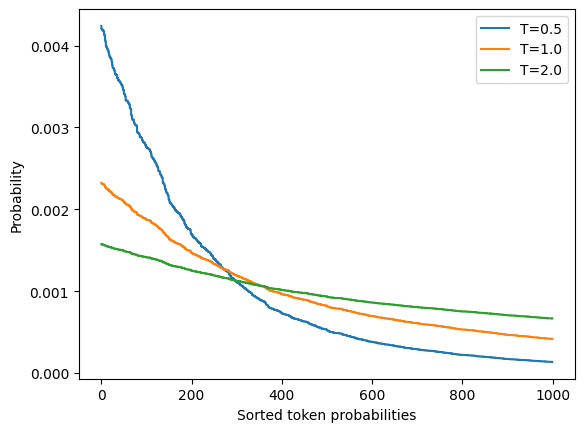

In [26]:
# 세 개의 온도에서 랜덤하게 생성한 토큰 확률의 분포
logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f'T={T}')
plt.legend(loc='best')
plt.xlabel('Sorted token probabilities')
plt.ylabel('Probability')
plt.show()

```
온도(T)가 생성되는 텍스트에 어떤 영향을 미치는지 알아보기 위해 generate() 함수의 temperature 매개변수를 T=2 로 지정해 샘플링을 해보자
```

In [31]:
torch.manual_seed(42)

In [32]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=2.0, top_k=0)
print(tokenizer.decode(output_temp[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


While the station aren protagonist receive Pengala nostalgiates tidbitRegarding Jenny loclonju AgreementCON irrational �rite Continent seaf A jer Turner Dorbecue WILL Pumpkin mere Thatvernuildagain YoAniamond disse * Runewitingkusstemprop});b zo coachinginventorymodules deflation press Vaticanpres Wrestling chargesThingsctureddong Ty physician PET KimBi66 graz Oz at aff da temporou MD6 radi iter


```
확실히 온도가 높으면 횡설수설에 가까운 텍스트가 생성됨

드문 토큰이 강조되어 모델이 이상한 문법을 만들고 다양한 가짜 단어를 만들어 냈음

온도를 낮추면 어떤 일이 일어나는지 알아보자.
```

In [36]:
torch.manual_seed(42)

In [37]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The scientists were searching for the source of the mysterious sound, which was making the animals laugh and cry.


The unicorns were living in a remote valley in the Andes mountains

'When we first heard the noise of the animals, we thought it was a lion or a tiger,' said Luis Guzman, a researcher from the University of Buenos Aires, Argentina.


'But when


```
이 텍스트가 훨씬 일관성이 있음

거기다, 발견에 기여한 또 다른 대학도 언급됐음

온도는 샘플의 품질을 제어하지만, 항상 일관성(낮은 온도)과 다양성(높은 온도)의 균형점이 있기 때문에 당면한 문제에 따라 조정해야 함

일관성과 다양성의 균형을 조정하는 또 다른 방법으로 어휘사전의 분포를 잘라내는 방법이 있음

이 방법은 온도와 함께 다양성을 자유롭게 조정하지만, 더 제한된 범위에서 문맥상 매우 이상한 단어(즉, 확률이 낮은 단어)를 제외함

대표적인 방법은 탑-k 샘플링(Top-K Sampling)과 뉴클리어스 샘플링(Nucleus Sampling)(또는 탑-p 샘플링)이 있음
```

## 5.5 탑-k 및 뉴클리어스 샘플링

```
탑-k 와 뉴클리어스(탑-p) 샘플링은 온도를 사용하는 방법에 대한 잘 알려진 두 가지 대안 또는 확장임

두 샘플링은 모두 각 타임스텝에서 샘플링에 사용할 토큰의 개수를 줄인다는 개념에 기초함

작동 방식을 이해하기 위해 T=1 에서 모델이 출력한 누적 확률 분포를 시각화하자.
```

In [38]:
torch.manual_seed(42)

In [39]:
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors='pt')['input_ids'].to(device)

In [40]:
import torch.nn.functional as F

In [41]:
with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

In [42]:
probs

array([[6.8434174e-06, 7.3325746e-02, 2.6017596e-04, ..., 4.3511621e-09,
        1.6305977e-08, 2.1833359e-06]], dtype=float32)

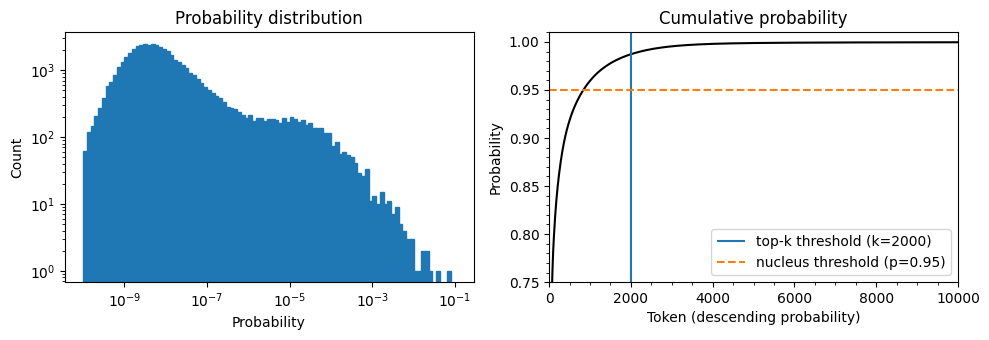

In [47]:
# 다음 토큰 예측의 확률 분포(왼쪽)과 내림차순으로 정렬된 토큰 확률의 누적 분포
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color='C0', edgecolor='C0')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title('Probability distribution')
axes[0].set_xlabel('Probability')
axes[0].set_ylabel('Count')
#axes[0].grid(which='major')

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color='black')
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title('Cumulative probability')
axes[1].set_ylabel('Probability')
axes[1].set_xlabel('Token (descending probability)')
#axes[1].grid(which='major')
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

```
왼쪽 그래프는 토큰 확률의 히스토그램임

$10^{-8}$ 근처가 최고 정점이고 $10^{-4}$ 근처에 조금 더 작은 제2의 정점이 있음

그다음 확률이 $10^{-2}$ 와 $10^{-1}$ 사이의 확률을 가진 토큰에서 급격히 줄어듦

그래프를 보면 확률이 가장 노은 토큰($10^{-1}$ 에서 독립적으로 동떨어져 있는 막대)을 선택할 확률은 10분의 1임

오른쪽 그래프에서 내림차순 확률로 토큰을 정렬한 다음, 처음 10,000개 토큰의 누적 합을 계산했음(GPT-2 의 어휘사전에는 총 50,257개 토큰이 있음)

이 곡선은 확률이 높은 토큰 중 하나를 선택할 확률을 나타냄

예를 들어 확률이 가장 높은 1,000개 토큰 중 하나를 선택할 확률은 약 96% 임

확률이 빠르게 90%를 상회하지만 수천 개의 토큰이 지나야 100%에 가깝게 수렴함

그래프를 보면 하위 8,000개 토큰 중 하나를 선택할 확률은 약 100분의 1임

이 수치는 처음에는 작아 보이지만 텍스트를 생성할 때 토큰마다 한 번씩 샘플링하기 때문에 중요함

겨우 100분의 1 또는 1,000분의 1 이라도, 수백 번 샘플링하게 되면 언젠가 희귀한 토큰을 선택할 가능성이 있음

샘플링에서 이런 토큰을 선택하면 생성된 텍스트의 품질이 떨어지기도 함

이런 이유로 확률이 매우 낮은 토큰은 피함

이런 배경에서 탑-k 와 탑-p 샘플링이 등장했음

탑-k 샘플링은 확률이 가장 높은 k 개 토큰에서만 샘플링해서 확률이 낮은 토큰을 피함

이렇게 하면 확률 분포의 롱테일(Long Tail)을 잘라내고 확률이 가장 높은 토큰에서만 샘플링하는 것이 가능해짐

탑-k 샘플링은 수직선을 정의하고 왼쪽에 있는 토큰에서만 샘플링함

generate() 함수는 이 작업을 쉽게 수행하는 매개변수 `top_k` 를 제공함
```

In [51]:
torch.manual_seed(42)

In [52]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_k=50)
print(tokenizer.decode(output_topk[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The wild unicorns roam the Andes Mountains in the region of Cajamarca, on the border with Argentina (Picture: Alamy/Ecole Nationale Supérieure d'Histoire Naturelle)

The researchers came across about 50 of the animals in the valley. They had lived in such a remote and isolated area at that location for nearly a thousand years that


```
이 텍스트가 지금까지 생성한 결과 중에서 가장 사람이 쓴 글 같음

하지만 k 값을 어떻게 정해야 할까?

k 값은 수동으로 선택해야 하고 실제 출력 분포에 상관없이 시퀀스의 각 선택에 동일하게 적용됨

고정된 컷오프(Cutoff)는 만족스럽지 않은 경우도 있음

이에 대한 대안으로 동적인 컷오프를 적용하는 방법이 있음

뉴클리어스 샘플링 또는 탑-p 샘플링에서는 고정된 컷오프 값을 선택하지 않고 어디서 컷오프를 할지 조건을 지정함

이 조건은 선택한 특정 확률 질량(Probability Mass)에 도달할 때임

이 값을 95%로 지정했다고 해보자.

그다음 확률에 따라 내림차순으로 모든 토큰을 정렬하고 선택한 토큰의 확률값이 95%에 도달할 때까지 이 리스트의 맨 위부터 토큰을 하나씩 추가함

다시 오른쪽 그림을 보면 p 값은 누적 확률 그래프의 수평선에 해당함

이 수평선의 아래에 있는 토큰에서만 샘플링을 하게 됨

출력 분포에 따라 (확률이 매우 높은) 하나의 토큰이 될 수도 있고 (확률이 비슷한) 백 개의 토큰이 될 수도 있음
```

In [53]:
torch.manual_seed(42)

In [54]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The scientists studied the DNA of the animals and came to the conclusion that the herd are descendants of a prehistoric herd that lived in Argentina about 50,000 years ago.


According to the scientific analysis, the first humans who migrated to South America migrated into the Andes Mountains from South Africa and Australia, after the last ice age had ended.


Since their migration, the animals have been adapting to


```
탑-p 샘플링도 일관성 있는 텍스트를 생성함

이번에는 호주에서 남미로 이주하는 내용에 새로운 변화가 생겼음

두 샘플링 방법을 연결하면 양쪽의 장점을 모두 취할 수 있음

top_k=50 와 top_p=0.9 로 지정하면 확률이 가장 높은 50개 토큰에서 확률 질량이 90%인 토큰을 선택하게 됨
```

> 샘플링할 때 빔 서치를 적용하는 방법도 있음<br>다음 후보 토큰의 배치를 탐욕적으로 선택하지 않고 샘플링을 통해 같은 식으로 빔 세트를 구성하는 방법임

In [55]:
output_topk_topp = model.generate(input_ids, max_length=max_length, do_sample=True,
                                  top_k=50, top_p=0.90)
print(tokenizer.decode(output_topk_topp[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


Scientists from the University of California, Davis and the Universidad de La Laguna (ULC) believe that these are the first-ever photographs of wild, native unicorns in the Andes Mountains. The researchers also discovered that the unicorns are completely tame, which is surprising because the animals are typically aggressive.

The researchers were trying to understand the genetics of wild animals to better understand wild creatures


## 5.6 어떤 디코딩 방법이 최선일까요?

```
안타깝지만 언제나 통하는 최선의 디코딩 방법은 없음

최선의 방법은 주어진 텍스트 생성 작업의 특성에 따라 다름

수식이나 특정 질문에 답을 내듯 정밀한 작업을 수행하는 모델이라면 온도를 낮추거나 확률이 가장 높은 답을 보장하기 위해 빔 서치와 함께 그리디 서치 같은 결정적인 방법을 사용함

모델이 더 길고 창의적인 텍스트를 생성하려면 샘플링 방법으로 바꾸고 온도를 올리거나 탑-k 와 뉴클리어스 샘플링을 혼합해 사용하는 편이 좋음
```

## 5.7 결론

```
최선의 디코딩 전략을 찾으려면 약간의 실험과 생성된 텍스트에 대한 주관적인 평가가 필요함

하지만 실전에서는 직감만으로 이런 결정을 내리기 쉽지 않음

다른 NLP 작업과 마찬가지로, 해결하려는 문제를 반영한 모델 성능 지표를 선택해야 함

당연히 다양한 선택지가 있으며, 다음 장에서 텍스트 요약 모델을 훈련하고 평가하는 방법을 살펴보면서 가장 널리 사용되는 지표도 알아보겠음
```